In [0]:
import json
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [0]:
#setup google drive credentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#get glove word embeddings
download = drive.CreateFile({'id': '<file id>'})
download.GetContentFile('filename')

In [0]:
#get dataset
download = drive.CreateFile({'id': '<file id>'})
download.GetContentFile('<file name>')

In [0]:
def load_data(path):
  '''Function to load data.
     Data is present in a json file
     parameters: filename->path to the json file
  '''  
  data = []
  labels = []
  fp = open(path,'r')
  for l in fp:
    dict_ = json.loads(l)
    data.append(dict_['headline'])
    labels.append(dict_['is_sarcastic'])
  return data,labels

In [62]:
#load the data
data,labels = load_data('<file name>')
print('Total no. of samples:',len(data))

Total no. of samples: 26709


In [0]:
#split into training and validation sets
def split_data(split_factor,data,labels):
  '''Function to split the data into training and testing sets
     parameters:
     split_factor-> fraction of data to be kept as training data
     data-> list of news headlines
     labels-> corresponding labels
  '''
  m = len(data) #size of the data
  num_train = int(m*split_factor)
  training_examples = data[0:num_train]
  testing_examples = data[num_train:]
  training_labels = labels[0:num_train]
  testing_labels = labels[num_train:]
  return training_examples,training_labels,testing_examples,testing_labels

In [0]:
#import tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
#tokenize and pad data
max_length = 40 
pad = 'post'
trunc = 'pre'
embedding_dim = 50
#generate indices for words(tokens)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
word_to_indices = tokenizer.word_index
vocab_size = len(word_to_indices)
#convert sentences to sequence of tokens
data_sequences = tokenizer.texts_to_sequences(data)
padded_sequences = pad_sequences(data_sequences,maxlen=max_length,padding = pad,truncating = trunc)

In [97]:
print(padded_train_sequences.shape)
print(padded_test_sequences.shape)
print(vocab_size)
print(word_to_indices['i'])

(24038, 150)
(2671, 150)
29656
79


In [103]:
split_factor = 0.9
train_x,train_y,test_x,test_y = split_data(split_factor,padded_sequences,labels)
train_y = np.array(train_y)
test_y = np.array(test_y)
print('no. of training examples=',len(train_x))
print('no. of testing examples=',len(test_x))
print(train_x)
print(train_x[0])
print(train_y[0])

no. of training examples= 24038
no. of testing examples= 2671
[[  307 15114   678 ...     0     0     0]
 [    3  8434  3337 ...     0     0     0]
 [  144   837     1 ...     0     0     0]
 ...
 [  858  1028 28116 ...     0     0     0]
 [   28   193   103 ...     0     0     0]
 [  236  5048  6740 ...     0     0     0]]
[  307 15114   678  3336  2297    47   381  2575 15115     5  2576  8433
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
0


In [0]:
def load_glove(path):
  '''
  This function loads the glove vectors into a dictionary
  parameters: path->path to the glove vector file
  '''
  fh = open(path,'r')
  word_to_embedding = {}
  for line in fh:
    line = line.strip().split()
    word = line[0]
    word_to_embedding[word] = np.array(line[1:],dtype='float32')
  fh.close()
  return word_to_embedding

In [0]:
word_to_embedding = load_glove('glove.6B.50D.txt')

In [106]:
print(len(word_to_embedding))

400000


In [0]:
def create_embedding_matrix(vocab_size,embedding_dim,word_indices,word_to_embedding):
  '''
  this function creates an embedding matrix using the glove vectors
  parameters:
  vocab_size: length of the vocabulary
  embedding_dim: length of the glove vectors
  word_indices: dictionary containing mapping from words to corresponding indices
  word_to_embedding: dictionary containing mapping from words to corresponding embedding
  '''
  embedding_matrix = np.zeros((vocab_size+1,embedding_dim))
  for word,idx in word_indices.items():
    if word_to_embedding.get(word) is not None:
      embedding_matrix[idx,:] = word_to_embedding[word]
  return embedding_matrix

In [0]:
#load embedding matrix
embedding_matrix = create_embedding_matrix(vocab_size,embedding_dim,word_to_indices,word_to_embedding)

print(len(embedding_matrix))

In [0]:
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('accuracy') > 0.95:
      self.model.stop_training = True
callbacks = myCallBack()

In [124]:
#create model
model = tf.keras.models.Sequential([
      tf.keras.layers.Embedding(vocab_size+1,embedding_dim,input_length=max_length,weights=[embedding_matrix],trainable=False),
      tf.keras.layers.LSTM(128,return_sequences=True),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.LSTM(128),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1,activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(lr=0.001,decay=1e-6)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 40, 50)            1482850   
_________________________________________________________________
lstm_28 (LSTM)               (None, 40, 128)           91648     
_________________________________________________________________
dropout_35 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_36 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 1,706,211
Trainable params: 223,361
Non-trainable params: 1,482,850
_____________________________________

In [127]:
#fit the data
num_epochs = 50
history = model.fit(train_x,train_y,batch_size=32,epochs=num_epochs,validation_data=(test_x,test_y),callbacks=[callbacks])

Epoch 1/50
752/752 [==============================] - 20s 27ms/step - loss: 0.4221 - accuracy: 0.8111 - val_loss: 0.4005 - val_accuracy: 0.8124
Epoch 2/50
752/752 [==============================] - 19s 26ms/step - loss: 0.3744 - accuracy: 0.8368 - val_loss: 0.3789 - val_accuracy: 0.8315
Epoch 3/50
752/752 [==============================] - 19s 26ms/step - loss: 0.3395 - accuracy: 0.8544 - val_loss: 0.3643 - val_accuracy: 0.8233
Epoch 4/50
752/752 [==============================] - 19s 25ms/step - loss: 0.3102 - accuracy: 0.8678 - val_loss: 0.3576 - val_accuracy: 0.8424
Epoch 5/50
752/752 [==============================] - 19s 26ms/step - loss: 0.2812 - accuracy: 0.8830 - val_loss: 0.3636 - val_accuracy: 0.8416
Epoch 6/50
752/752 [==============================] - 19s 26ms/step - loss: 0.2574 - accuracy: 0.8958 - val_loss: 0.3427 - val_accuracy: 0.8484
Epoch 7/50
752/752 [==============================] - 19s 26ms/step - loss: 0.2280 - accuracy: 0.9099 - val_loss: 0.3448 - val_accuracy:

<Figure size 432x288 with 0 Axes>

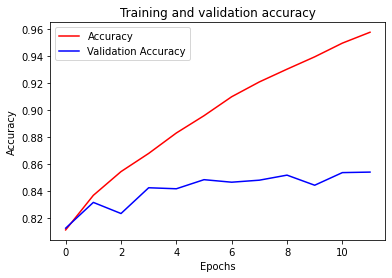

<Figure size 432x288 with 0 Axes>

In [128]:
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs=range(len(acc))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()